# Basic IEM from Brouwer and Heeger 2009
[click here for a matlab version of this by Tommy Sprague](https://github.com/tommysprague/IEM-tutorial)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# just to make things look a little bit cooler
import seaborn as sns
sns.set()

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## The data file for the demo (thanks to Mary Smith) contains fMRI data and some info about the experimental design.
* myLBetas and myRBetas: n_trials x n_voxels signals extracted from each
* voxel of LH & RH V1, respectively
* myOrL and myOrR: n_trials x 1 orientation labels for the orientation
* presented on the left and right HEMISPHERES, respectively (opposite
* side of screen; arranged this way for convenience)
* myAttnSide: n_trials x 1, label for which side was attended (L or R, 1 or 2, respectively)

In [2]:
# load the data
fname = "s03_data.npz"
data = np.load(fname)

# print out contents and size
for k,v in data.items():
    print('Field:', k, 'with size:', v.shape)
    
# assign to np arrays
myOrL = data['myOrL']
myOrR = data['myOrR']
myLbetas = data['myLbetas']
myRbetas = data['myRbetas']
myAttnSide = data['myAttnSide']

Field: myOrL with size: (288,)
Field: myOrR with size: (288,)
Field: myAttnSide with size: (288,)
Field: myLbetas with size: (288, 209)
Field: myRbetas with size: (288, 220)


## Each data file contains 8 scanning runs, with 36 trials each. 
* Here, create a array that keeps track of run number for cross-validation of the model (i.e. leave-one-out cross-val)

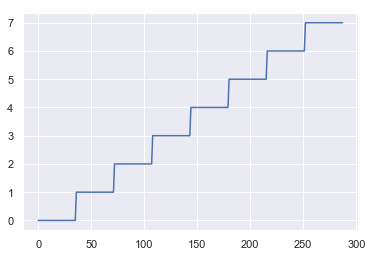

In [3]:
# number of scanning runs and trials per run
n_runs = 8
n_trials = 36

# init array with nans so we can verify that we filled it completely 
scan_num = np.full((n_runs*n_trials), np.nan)

# loop and assign consecutive blocks of 36 entries to incrementing values
for i in np.arange(0,n_runs):
    scan_num[i*n_trials:(i+1)*n_trials] = i * np.ones((n_trials))
    
# plot it out to make sure it makes sense...should be step function from 0...7
plt.plot(scan_num)
plt.show()

# then a few quick checks to make sure that the array was filled correctly
if np.isnan(scan_num).any() or (np.mean(scan_num) != (n_runs-1)/2):
     print('ERROR - array fill failed')

# Generate orientation channels (orientation filters)
* Use orientation tuning functions (TFs), modeled as sinusoids raised to a high power to model orientation channels  
* Here we'll use 9 channels....
* Each orientation channel can be modeled as a "steerable filter" (see Freeman and Adelson, 1991), which here is a (co)sinusoid raised to a high power (specifically, n_ori_chans-1). 

In [4]:
# lambda functions to convert deg 2 radian in cos func so that you can deal with degrees in rest of code
# and another func to generate channels
cosd = lambda x : np.cos( np.deg2rad(x) )
make_basis_function = lambda xx,mu : np.power( (cosd(xx-mu) ), ( n_ori_chans - (n_ori_chans % 2) ) )

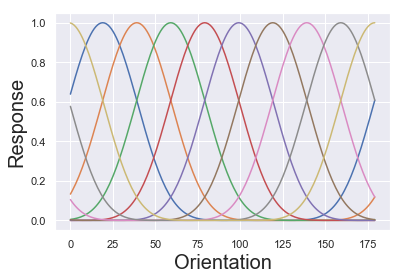

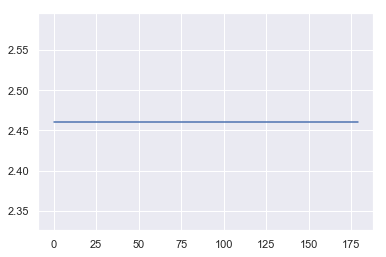

In [5]:
# define the number of orientation channels that we want to use
n_ori_chans = 9

# can use degrees for ease of reading...
xx = np.linspace(0,179,180)

# generate an array to store the orientation channel responses 
# doing this to visualize what the complete basis set looks like
basis_set = np.full( (180 , n_ori_chans) , np.nan)

# center of each orientation channel - dependent on the number of channels that you have
chan_center = np.linspace(180/n_ori_chans, 180, n_ori_chans) - 1
for c in np.arange(0,n_ori_chans):
    basis_set[:,c] = make_basis_function(xx,chan_center[c])

# make a quick plot...
plt.plot(basis_set)
plt.xlabel('Orientation', **fig_font)
plt.ylabel('Response', **fig_font)
plt.show()

# then make sure that we've tiled the space (uniformly covered it)
# if we did it right, we should see a straight line
plt.plot(np.sum(basis_set,axis=1))
plt.show()

## Start the actual IEM analysis - Step 1 is building a stimulus mask
* Create an "image" of the portion of the feature space (orientation) occupied by the visual stimulus/stimuli for each set of voxels. 
    * Note that since this study requires analyzing data from the left and right hemispheres separately here, we'll only consider the relevant orientation.

* The stimulus "image" should be the same dimensionality as the basis function vectors (here, 180 points). Because we're using square-wave, single-orientation gratings (that is, they have a single orientation value, and are not superimposed w/ other orientations as could be the case w/ plaids or other complex stimuli), we can consider the stimulus images to be a vector of 0's, w/ a single value of 1 at the stimulus orientation. Note that the basis set vectors and stimulus image can each be as high- or low-resolution as you like (down to n_channels values).
* Here, we'll use 180 points, 1 point for each degree.


In [6]:
# convert the orientation labels (1:9) to orientation value (0:160)
myOrL_Deg = myOrL.copy()
myOrR_Deg = myOrR.copy()
myOrL_Deg *= 20
myOrR_Deg *= 20

# must -1 here cause we'll use this to index into a matrix with 180 columns (stims masks, see below)
# this is one of the matlab-to-python moments where we have to account for zero-based counting to change
# this from 0...179
myOrL_Deg -= 1
myOrR_Deg -= 1

# should be 19,39,179...
print(np.unique(myOrL_Deg))
print(np.unique(myOrR_Deg))

[ 19  39  59  79  99 119 139 159 179]
[ 19  39  59  79  99 119 139 159 179]


### Then build the stim masks

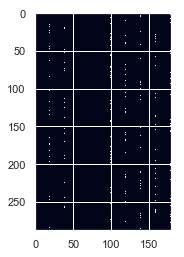

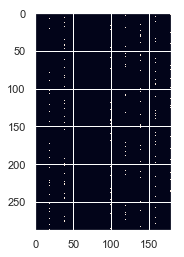

In [7]:
r = len(myOrL_Deg)
stim_mask_L = np.zeros( (r,len(xx)) )
stim_mask_R = np.zeros( (r,len(xx)) )

# loop over trials and build a stim mask for each based on orientation of each stim
for t in np.arange(0,r):
    stim_mask_L[t,myOrL_Deg[t]]=1
    stim_mask_R[t,myOrR_Deg[t]]=1

# imshow to look at the masks. 
plt.imshow(stim_mask_L)
plt.show()
plt.imshow(stim_mask_R)
plt.show()

### Generate design matrix
* Each voxel is modeled as a linear combination of a set of hypothetical neural populations, or information channels, which are modeled as orientation TFs (see above). The set of TFs forms our "basis set" (see above), which is used to generate predictions for how each channel should respond to any given stimulus value. Let's generate those predictions as a matrix of trials x channels, called a "design matrix"

* Because we've computed "stimulus images", we just need to project each stimulus image onto the n_ori_chans basis functions. 


In [8]:
trnX_L = stim_mask_L @ basis_set
trnX_R = stim_mask_R @ basis_set

### Make sure that we have a full rank design matrix
* Test to see if channels are colinear...if so then can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. 

In [9]:
print('Design matrix L: rank = {}\nDesign matrix R: rank = {}'.format(np.linalg.matrix_rank(trnX_L),np.linalg.matrix_rank(trnX_R)))

Design matrix L: rank = 9
Design matrix R: rank = 9


## Next, do leave-one-out cross-validation and train/test encoding model within each hemisphere

* As with any machine learning or model-fitting it's important to be sure the data used to estimate a model (the weights for each voxel) is entirely independent of the data used to evaluate the model's efficacy or here, to reconstruct stimulus representations. 
* Because we z-scored the timeseries of each voxel within each run during preprocessing, data within a run are not independent. 
* In addition, there are temporal auto-correlations that render data from adjacent trials non-independent. 
* So here, we'll implement a leave-one-run-out cross-validation scheme for encoding model estimation and reconstruction. We'll use runs 1-(n-1) for model estimation, then map activation patterns from run n into the feature space using the map computed from runs 1-(n-1).


In [10]:
# figure out how many runs...we know this already because we 
# hard coded above, but include here as a note that its 
# important to separate data on a run-by-run basis
unique_runs = np.unique(scan_num)
n_runs = len(unique_runs)

# allocate array to store channel outputs...
chan_resp_L = np.full( trnX_L.shape , np.nan )

# start a loop over runs to implement the LOO procedure
for r in np.arange(0, n_runs):
    
    # identify the training & testing parts of the data - need these to be independent!
    trn_idx = scan_num != unique_runs[r]
    tst_idx = scan_num == unique_runs[r]
    
    trnL = myLbetas[trn_idx,:]
    tstL = myLbetas[tst_idx,:]

    # train the encoding model...remember, each hemisphere is separate here,
    # so must do this for each hemisphere seperately - here, just doing
    # LH for an example
    w = np.linalg.solve(trnX_L[trn_idx,:].T @ trnX_L[trn_idx,:], trnX_L[trn_idx,:].T) @ trnL
    chan_resp_L[tst_idx,:] = (np.linalg.solve(w @ w.T, w) @ tstL.T).T

In [11]:
# then after the loop, roll (shift) the chan response on each trial to a common center
cent = 5
cent_chan_response = np.zeros( chan_resp_L.shape )
for c in np.arange(0,chan_resp_L.shape[0]):
    cent_chan_response[c,:] = np.roll(chan_resp_L[c,:], cent-myOrL[c])

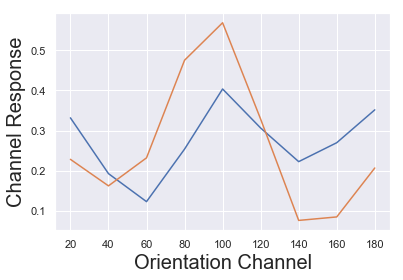

In [12]:
# plot the chnanle responses. 
oris = np.unique(myOrL_Deg)+1
plt.plot(oris, np.mean(cent_chan_response[myAttnSide==1,:],axis=0))
plt.plot(oris, np.mean(cent_chan_response[myAttnSide==2,:],axis=0))
plt.xlabel('Orientation Channel', **fig_font)
plt.ylabel('Channel Response', **fig_font)
plt.show()